# TODO:
        1) improve wordcloud
        2) BERT? maybe?
        3) visualizations
        4) do something with the classification dictionary?? unsure
            - SVC is clear winner in all metrics but i want to make it easier to look at
        4) train unique RNN? ehhhhh

In [169]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [86]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
# Load in training data
train = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
df = train.copy()
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [88]:
# Load in test data
test_df = pd.read_csv('Corona_NLP_test.csv', encoding = 'latin1')
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [89]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [90]:
# Replace na with 'None'
df['Location'].fillna('None', inplace = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [91]:
# Join stopwords together and set them for use in cleaning function.
", ".join(stopwords.words('english'))
stops = set(stopwords.words('english'))

# Function that cleans tweets for classification. 
def clean_tweet(tweet):
    # Remove hyperlinks.
    tweet= re.sub(r'https?://\S+|www\.\S+','',tweet)
    # Remove html
    tweet = re.sub(r'<.*?>','',tweet)
    # Remove numbers (Do we want to remove numbers? Death toll?)
    tweet = re.sub(r'\d+','',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+','',tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s\d]','',tweet)
    # Remove whitespace
    tweet = re.sub(r'\s+',' ',tweet).strip()
    # Remove stopwords
    tweet = " ".join([word for word in str(tweet).split() if word not in stops])
    
    return tweet.lower()

In [92]:
# Check function
example2 = df['OriginalTweet'][1]
clean_tweet(example2)

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [93]:
# Apply text cleaning function to training and test dataframes.
df['newTweet'] = df['OriginalTweet'].apply(lambda x: clean_tweet(x))
test_df['newTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_tweet(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...


In [94]:
# Create more useful labels for classification.
# We will take the original 5 possibilites and
# reduce them to 3, removing the "extremelys".
def make_label(sentiment):
    
    label = ''
    if 'Positive' in sentiment: 
        label = 1
    if 'Negative' in sentiment:
        label = -1
    if 'Neutral' in sentiment:
        label = 0
    return label

In [95]:
# Sanity check
print(make_label('Extremely Negative'))
print(make_label('Extremely Positive'))
print(make_label('Neutral'))

-1
1
0


In [96]:
# Apply make_label funtion to training and test dataframes.
df['label'] = df['Sentiment'].apply(lambda x: make_label(x))
test_df['label'] = test_df['Sentiment'].apply(lambda x: make_label(x))
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,newTweet,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...,1
3,3802,48754,None,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock one empty please dont panic ther...,1
4,3803,48755,None,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready go supermarket covid outbreak not im ...,-1


In [97]:
# Set X and y to proper data.
X = df['newTweet']
y = df['label']

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [98]:
# Define dictionary of classification methods.
clf = dict({'SVC': LinearSVC(),
            'Logisitc': LogisticRegression(max_iter = 5000),
            'NaiveBayes': MultinomialNB(),
            'RandomForest': RandomForestClassifier(),
           })

In [99]:
def models(clf, vectorizer, X_train, X_test, y_train, y_test):
    """
    Input:
        clf: dictionary containing classification methods
        vectorizer: ex TfidfVectorizer, CountVectorizer
        X_train: X training data
        X_test: X testing data
        y_train: y training labels
        y_test: y testing label
    
    Output: 
        Classification report and accuracy of each method
        accuracy_dict: a dictionary containing the accuracies of each method
        clf_dict: a dictionary containing classification results of each method
    """
    
    accuracy_dict = {}
    clf_dict = {}
    for classifier in clf.keys():
        model = Pipeline([('vectorizer',vectorizer),
                    ('clf', clf[classifier]),
                    ])
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        accuracy_dict[classifier] = accuracy_score(y_test,preds)
        clf_dict[classifier] = classification_report(y_test,preds, output_dict = True)
        
        print(classifier)
        print(classification_report(y_test,preds))
        print(classifier + ' Accuracy:', accuracy_score(y_test,preds))
        print('\n')
        
    return accuracy_dict, clf_dict
        

In [100]:
tfidf_acc, tfidf_clf = models(clf, TfidfVectorizer(), X_train, X_test, y_train, y_test)

SVC
              precision    recall  f1-score   support

          -1       0.80      0.81      0.81      5053
           0       0.72      0.66      0.69      2518
           1       0.84      0.86      0.85      6011

    accuracy                           0.80     13582
   macro avg       0.79      0.78      0.78     13582
weighted avg       0.80      0.80      0.80     13582

SVC Accuracy: 0.8034899131203063


Logisitc
              precision    recall  f1-score   support

          -1       0.77      0.80      0.79      5053
           0       0.73      0.57      0.64      2518
           1       0.80      0.85      0.83      6011

    accuracy                           0.78     13582
   macro avg       0.77      0.74      0.75     13582
weighted avg       0.78      0.78      0.78     13582

Logisitc Accuracy: 0.7810337211014579


NaiveBayes
              precision    recall  f1-score   support

          -1       0.73      0.63      0.68      5053
           0       0.86      0

In [101]:
tfidf_acc

{'SVC': 0.8034899131203063,
 'Logisitc': 0.7810337211014579,
 'NaiveBayes': 0.6402591665439552,
 'RandomForest': 0.7299366809011928}

In [157]:
tfidf_clf['SVC']['weighted avg']['precision']

0.8019088949915633

In [159]:
tfidf_clf.keys()

dict_keys(['SVC', 'Logisitc', 'NaiveBayes', 'RandomForest'])

In [162]:
svc = tfidf_clf['SVC']
svc

{'-1': {'precision': 0.8046675818787997,
  'recall': 0.8119928755194934,
  'f1-score': 0.808313632781718,
  'support': 5053},
 '0': {'precision': 0.7162510748065348,
  'recall': 0.6616362192216044,
  'f1-score': 0.6878612716763005,
  'support': 2518},
 '1': {'precision': 0.8354718206918954,
  'recall': 0.855764431874896,
  'f1-score': 0.8454963839579225,
  'support': 6011},
 'accuracy': 0.8034899131203063,
 'macro avg': {'precision': 0.7854634924590767,
  'recall': 0.776464508871998,
  'f1-score': 0.7805570961386471,
  'support': 13582},
 'weighted avg': {'precision': 0.8019088949915633,
  'recall': 0.8034899131203063,
  'f1-score': 0.8024386859444866,
  'support': 13582}}

In [164]:
neg_svc = svc['-1']
neg_svc

{'precision': 0.8046675818787997,
 'recall': 0.8119928755194934,
 'f1-score': 0.808313632781718,
 'support': 5053}

In [107]:
tfidf_acc_df = pd.DataFrame.from_dict(tfidf_acc, orient = 'index', columns = ['accuracy'])

In [128]:
tfidf_acc_df['method'] = tfidf_acc_df.index
tfidf_acc_df

,accuracy,method
SVC,0.803490,SVC
Logisitc,0.781034,Logisitc
NaiveBayes,0.640259,NaiveBayes
RandomForest,0.729937,RandomForest


In [127]:
tfidf_clf_df = pd.DataFrame.from_dict(tfidf_clf)

In [170]:
tfidf_clf_df.head()

,SVC,Logisitc,NaiveBayes,RandomForest
-1,"{'precision': 0.8046675818787997, 'recall': 0....","{'precision': 0.7731012052802755, 'recall': 0....","{'precision': 0.7327842598947609, 'recall': 0....","{'precision': 0.7506843546009686, 'recall': 0...."
0,"{'precision': 0.7162510748065348, 'recall': 0....","{'precision': 0.7345679012345679, 'recall': 0....","{'precision': 0.8571428571428571, 'recall': 0....","{'precision': 0.6284569138276553, 'recall': 0...."
1,"{'precision': 0.8354718206918954, 'recall': 0....","{'precision': 0.8015910154422087, 'recall': 0....","{'precision': 0.5949574328749181, 'recall': 0....","{'precision': 0.7543389081729253, 'recall': 0...."
accuracy,0.80349,0.781034,0.640259,0.729937
macro avg,"{'precision': 0.7854634924590767, 'recall': 0....","{'precision': 0.769753373985684, 'recall': 0.7...","{'precision': 0.7282948499708454, 'recall': 0....","{'precision': 0.711160058867183, 'recall': 0.7..."


In [174]:
hope = pd.DataFrame.from_dict(tfidf_clf['SVC'])
hope.head()

,-1,0,1,accuracy,macro avg,weighted avg
precision,0.804668,0.716251,0.835472,0.80349,0.785463,0.801909
recall,0.811993,0.661636,0.855764,0.80349,0.776465,0.803490
f1-score,0.808314,0.687861,0.845496,0.80349,0.780557,0.802439
support,5053.000000,2518.000000,6011.000000,0.80349,13582.000000,13582.000000


In [175]:
hope.T

,precision,recall,f1-score,support
-1,0.804668,0.811993,0.808314,5053.00000
0,0.716251,0.661636,0.687861,2518.00000
1,0.835472,0.855764,0.845496,6011.00000
accuracy,0.803490,0.803490,0.803490,0.80349
macro avg,0.785463,0.776465,0.780557,13582.00000
weighted avg,0.801909,0.803490,0.802439,13582.00000


In [177]:
df['newTweet']

0                                                         
1        advice talk neighbours family exchange phone n...
2        coronavirus australia woolworths give elderly ...
3        my food stock one empty please dont panic ther...
4        me ready go supermarket covid outbreak not im ...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing covid relat...
41154    you know itâs getting tough rationing toilet p...
41155    is wrong smell hand sanitizer starting turn co...
41156    well newused rift s going amazon rn although n...
Name: newTweet, Length: 41157, dtype: object

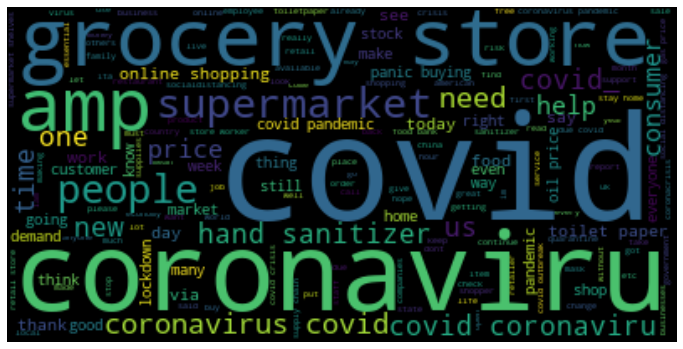

In [181]:
# There's gotta be a better way to do this...
text = ''
for row in df['newTweet']:
        tokens = str(row).split()
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower()
        text += " ".join(tokens)+" "

wordcloud = WordCloud().generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [156]:
tfidf_clf_df.iloc[-1]

SVC             {'precision': 0.8019088949915633, 'recall': 0....
Logisitc        {'precision': 0.7785661875580172, 'recall': 0....
NaiveBayes      {'precision': 0.6948412390329166, 'recall': 0....
RandomForest    {'precision': 0.7296417118130013, 'recall': 0....
Name: weighted avg, dtype: object

<AxesSubplot:xlabel='method', ylabel='accuracy'>

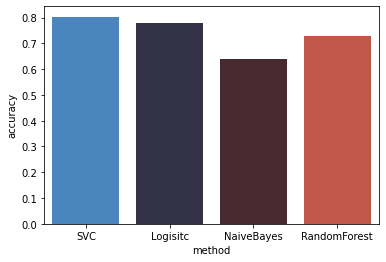

In [144]:
sns.barplot(x = 'method', y = 'accuracy', data = tfidf_acc_df, palette = 'icefire')